In [4]:
import os
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten,InputLayer
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import csv
import scipy
%matplotlib inline
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [5]:
#PARAMETERS SETTING

DAMPING_FACTOR = 10
PHASE_SHIFT =0
DELTA_FREQUENCY =123.2
DELTA_BETA = 0
DELTA_ALPHA =-0.026
NDP =2048

In [6]:
df = pd.read_csv("./mrs_datasets.csv")

In [7]:
df.head()

,imag_component,real_component,ace_imag,ace_real,ala_imag,ala_real,asc_imag,asc_real,asp_imag,asp_real,...,naag_imag,naag_real,pcho_imag,pcho_real,pcr_imag,pcr_real,pe_imag,pe_real,tau_imag,tau_real
0,103.39270,267.478460,0.00000,3.100000,0.034923,2.769480,0.008175,3.83645,-0.070215,2.153580,...,-0.224074,8.76237,-0.000002,12.14190,0.00000,5.10000,-0.000055,3.01880,-3.000000e-07,3.92162
1,208.88067,475.039650,-1.59678,2.643850,-1.425420,2.328820,-0.535391,3.75273,-0.743603,1.964530,...,-3.729120,7.74945,-3.015710,11.70030,-1.27955,4.88867,-0.671965,2.93129,-1.041460e+00,3.74859
2,362.25272,321.308610,-2.71081,1.430540,-2.352400,1.147570,-1.004860,3.55094,-1.264100,1.545000,...,-6.319120,5.24486,-5.756960,10.46610,-2.40047,4.31520,-1.258190,2.66288,-1.954820e+00,3.28968
3,427.01000,128.034040,-3.02747,-0.162387,-2.426660,-0.310499,-1.374670,3.29898,-1.561160,1.006050,...,-7.413620,1.89018,-8.019600,8.59008,-3.26274,3.48772,-1.712500,2.28873,-2.667710e+00,2.63528
4,382.59452,-45.193075,-2.48820,-1.662300,-1.670910,-1.495770,-1.675670,3.05325,-1.641010,0.461769,...,-6.829890,-1.49316,-9.685960,6.25744,-3.83935,2.52442,-2.048340,1.87846,-3.172140e+00,1.87632


In [8]:
df.describe()

,imag_component,real_component,ace_imag,ace_real,ala_imag,ala_real,asc_imag,asc_real,asp_imag,asp_real,...,naag_imag,naag_real,pcho_imag,pcho_real,pcr_imag,pcr_real,pe_imag,pe_real,tau_imag,tau_real
count,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,...,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000
mean,0.888362,0.022842,-0.002747,0.000878,-0.002801,0.000771,-0.024353,0.002056,-0.004036,0.000645,...,-0.020442,-0.015210,-0.026423,0.003639,-0.011812,0.001788,-0.008142,0.000560,-0.007346,0.001000
std,20.312742,19.385899,0.836298,0.837712,0.527957,0.529806,0.428493,0.434801,0.216379,0.218922,...,0.966210,0.980368,2.524436,2.531886,1.004969,1.008287,0.291489,0.294802,0.434440,0.438984
min,-79.653652,-214.828250,-3.027470,-2.970990,-2.426660,-2.206440,-2.919780,-2.102230,-1.641010,-1.525520,...,-7.413620,-5.466440,-11.051500,-9.235690,-4.220290,-4.303890,-2.668320,-1.683720,-3.656880,-3.617810
25%,-3.272611,-3.555623,-0.322057,-0.319175,-0.178390,-0.176367,-0.120600,-0.109261,-0.068676,-0.066385,...,-0.335157,-0.325655,-0.984788,-0.985895,-0.328275,-0.329649,-0.074193,-0.077719,-0.064095,-0.066167
50%,0.203375,-0.032878,-0.000143,0.001086,-0.000985,-0.000642,0.000722,0.000665,0.001977,-0.000242,...,-0.014061,-0.002871,-0.014287,0.001951,-0.001874,0.001041,-0.001151,0.000276,-0.000173,-0.000353
75%,3.393012,3.135960,0.319927,0.324569,0.170996,0.172634,0.111238,0.123372,0.068849,0.065565,...,0.307591,0.299814,0.947504,0.975601,0.319130,0.328891,0.073650,0.075345,0.065186,0.067182
max,427.010000,475.039650,2.855430,3.100000,2.055490,2.769480,1.477380,3.836450,1.261670,2.153580,...,5.522700,8.762370,8.414550,12.141900,4.700240,5.100000,1.975330,3.018800,3.474780,3.921620


In [9]:
#Plots of the real part of FID Signals of selected metabolites
#Notice it is decaying

/home/dronny/anaconda3/envs/tensorflow/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


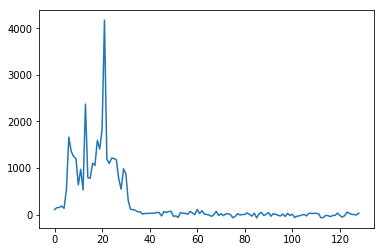

In [10]:
real_component_truncated = df.real_component[:256]
fft_truncated_water_removed = np.fft.rfft(real_component_truncated)
plt.plot(fft_truncated_water_removed)

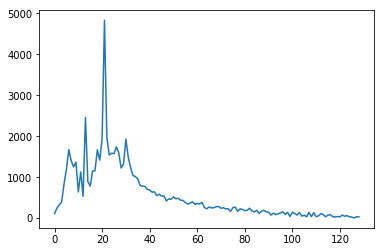

In [11]:
A =np.abs(fft_truncated_water_removed)
plt.plot(A)

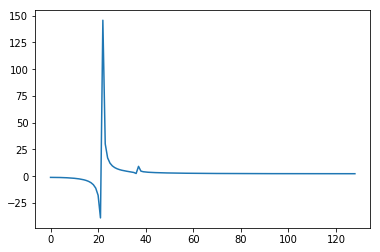

In [12]:
truncated_ace_real = df.ace_real[:256]
fft_ace_real =np.fft.rfft(truncated_ace_real)
plt.plot(fft_ace_real)

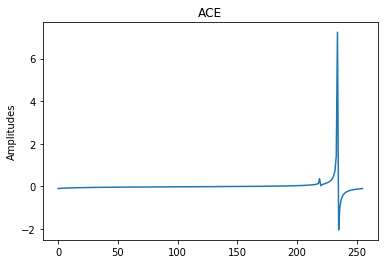

In [13]:
##ace metabolite signal
truncated_ace_real = df.ace_real[:256]
truncated_ace_imag = df.ace_imag[:256]
td_aces =[]
for i in np.arange(len(truncated_ace_real)):
    td_ace = complex(truncated_ace_real[i],truncated_ace_imag[i])
    td_aces.append(td_ace)
    
fd_ace =np.fft.fft(td_aces)
fd_ace -=fd_ace.mean()
fd_ace/=fd_ace.std()

plt.plot(fd_ace.real)
plt.title("ACE")
plt.ylabel("Amplitudes")
plt.show()

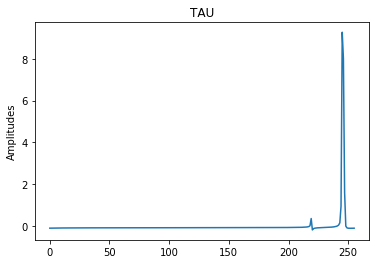

In [14]:
## tau metabolite
truncated_tau_real = df.tau_real[:256]
truncated_tau_imag = df.tau_imag[:256]
td_taus =[]
for i in np.arange(len(truncated_tau_real)):
    td_tau = complex(truncated_tau_real[i],truncated_tau_imag[i])
    td_taus.append(td_tau)
    
    
fd_taus =np.fft.fft(td_taus)
fd_taus -=fd_taus.mean()
fd_taus/=fd_taus.std()

plt.plot(fd_taus.real)
plt.title("TAU")
plt.ylabel("Amplitudes")
plt.show()

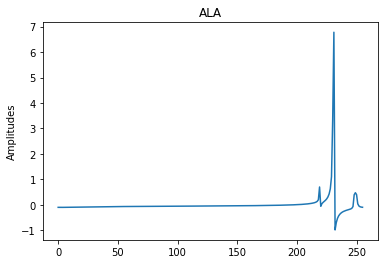

In [15]:
##creating a time domian signal for ala metabolite
truncated_ala_real = df.ala_real[:256]
truncated_ala_imag = df.ala_imag[:256]
td_alas =[]
for i in np.arange(len(truncated_ala_real)):
    td_ala = complex(truncated_ala_real[i],truncated_ala_imag[i])
    td_alas.append(td_ala)
    
    
fd_alas =np.fft.fft(td_alas)
fd_alas -=fd_alas.mean()
fd_alas/=fd_alas.std()
plt.plot(fd_alas.real)
plt.title("ALA")
plt.ylabel("Amplitudes")
plt.show()

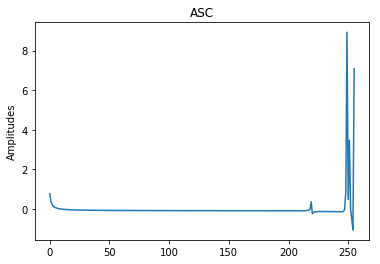

In [16]:
##creating a time domian signal for asc metabolite
truncated_asc_real = df.asc_real[:256]
truncated_asc_imag = df.asc_imag[:256]
td_ascs =[]
for i in np.arange(len(truncated_asc_real)):
    td_asc = complex(truncated_asc_real[i],truncated_asc_imag[i])
    td_ascs.append(td_asc)

fd_ascs =np.fft.fft(td_ascs)
fd_ascs -=fd_ascs.mean()
fd_ascs/=fd_ascs.std()
plt.plot(fd_ascs.real)
plt.title("ASC")
plt.ylabel("Amplitudes")
plt.show()

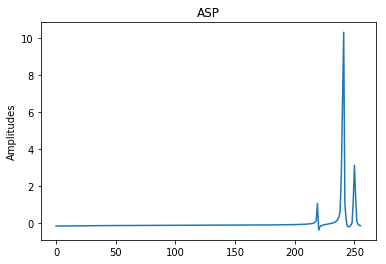

In [17]:
##creating a time domian signal for asp metabolite
truncated_asp_real = df.asp_real[:256]
truncated_asp_imag = df.asp_imag[:256]
td_asps =[]
for i in np.arange(len(truncated_asp_real)):
    td_asp = complex(truncated_asp_real[i],truncated_asp_imag[i])
    td_asps.append(td_asp)

    
fd_asps =np.fft.fft(td_asps)
fd_asps -=fd_asps.mean()
fd_asps/=fd_asps.std()
plt.plot(fd_asps.real)
plt.title("ASP")
plt.ylabel("Amplitudes")
plt.show()

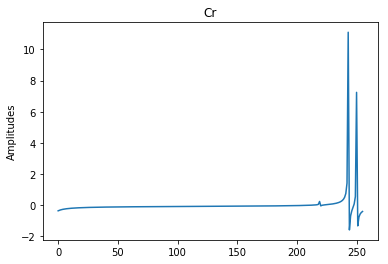

In [18]:
##creating a time domian signal for cr metabolite
truncated_cr_real = df.cr_real[:256]
truncated_cr_imag = df.cr_imag[:256]
td_crs =[]
for i in np.arange(len(truncated_cr_real)):
    td_cr = complex(truncated_cr_real[i],truncated_cr_imag[i])
    td_crs.append(td_cr)
    
fd_crs =np.fft.fft(td_crs)
fd_crs -=fd_crs.mean()
fd_crs/=fd_crs.std()
plt.plot(fd_crs.real)
plt.title("Cr")
plt.ylabel("Amplitudes")
plt.show()

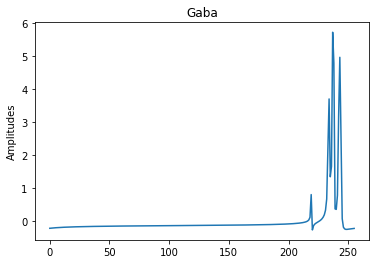

In [19]:
##creating a time domian signal for gaba metabolite
truncated_gaba_real = df.gaba_real[:256]
truncated_gaba_imag = df.gaba_imag[:256]
td_gabas=[]
for i in np.arange(len(truncated_gaba_real)):
    td_gaba = complex(truncated_gaba_real[i],truncated_gaba_imag[i])
    td_gabas.append(td_gaba)
    
fd_gabas =np.fft.fft(td_gabas)
fd_gabas -=fd_gabas.mean()
fd_gabas/=fd_gabas.std()
plt.plot(fd_gabas.real)
plt.title("Gaba")
plt.ylabel("Amplitudes")
plt.show()

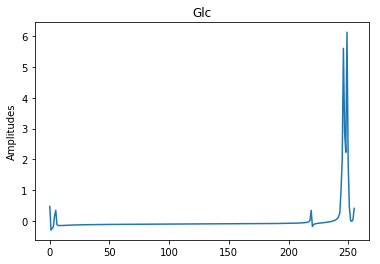

In [20]:
##creating a time domian signal for glc metabolite
truncated_glc_real = df.glc_real[:256]
truncated_glc_imag = df.glc_imag[:256]
td_glcs =[]
for i in np.arange(len(truncated_glc_real)):
    td_glc = complex(truncated_glc_real[i],truncated_glc_imag[i])
    td_glcs.append(td_glc)
    
fd_glcs =np.fft.fft(td_glcs)
fd_glcs -=fd_glcs.mean()
fd_glcs/=fd_glcs.std()
plt.plot(fd_glcs.real)
plt.title("Glc")
plt.ylabel("Amplitudes")
plt.show()

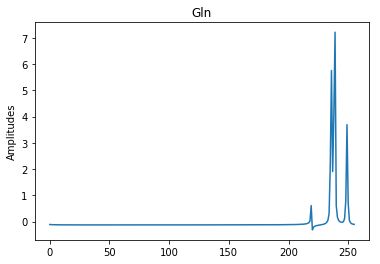

In [21]:
##creating a time domian signal for gln metabolite
truncated_gln_real = df.gln_real[:256]
truncated_gln_imag = df.gln_imag[:256]
td_glns =[]
for i in np.arange(len(truncated_gln_real)):
    td_gln = complex(truncated_gln_real[i],truncated_gln_imag[i])
    td_glns.append(td_gln)
    
fd_glns =np.fft.fft(td_glns)
fd_glns -=fd_glns.mean()
fd_glns/=fd_glns.std()
plt.plot(fd_glns.real)
plt.title("Gln")
plt.ylabel("Amplitudes")
plt.show()

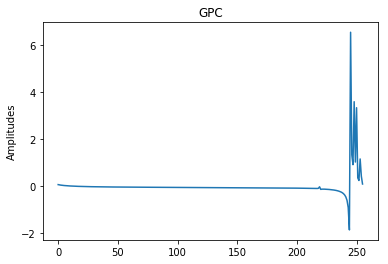

In [ ]:
##creating a time domian signal for gpc metabolite
truncated_gpc_real = df.gpc_real[:256]
truncated_gpc_imag = df.gpc_imag[:256]
td_gpcs =[]
for i in np.arange(len(truncated_gpc_real)):
    td_gpc = complex(truncated_gpc_real[i],truncated_gpc_imag[i])
    td_gpcs.append(td_gpc)
    
    
fd_gpcs =np.fft.fft(td_gpcs)
fd_gpcs -=fd_gpcs.mean()
fd_gpcs/=fd_gpcs.std()
plt.plot(fd_gpcs.real)
plt.title("GPC")
plt.ylabel("Amplitudes")
plt.show()

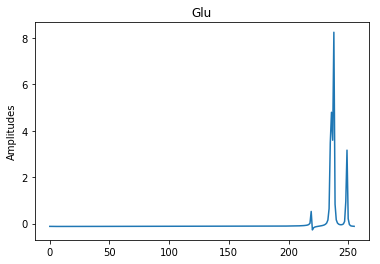

In [ ]:
##creating a time domian signal for glu metabolite
truncated_glu_real = df.glu_real[:256]
truncated_glu_imag = df.glu_imag[:256]
td_glus =[]
for i in np.arange(len(truncated_glu_real)):
    td_glu = complex(truncated_glu_real[i],truncated_glu_imag[i])
    td_glus.append(td_glu)
    
fd_glus =np.fft.fft(td_glus)
fd_glus -=fd_glus.mean()
fd_glus/=fd_glus.std()
plt.plot(fd_glus.real)
plt.title("Glu")
plt.ylabel("Amplitudes")
plt.show()

In [ ]:
##creating a time domian signal for gly metabolite
truncated_gly_real = df.gly_real[:256]
truncated_gly_imag = df.gly_imag[:256]
td_glys =[]
for i in np.arange(len(truncated_gly_real)):
    td_gly = complex(truncated_gly_real[i],truncated_gly_imag[i])
    td_glys.append(td_glys)
    
fd_glys =np.fft.fft(td_glys)
fd_glys -=fd_glys.mean()
fd_glys/=fd_glys.std()
plt.plot(fd_glys.real)
plt.title("Gly")
plt.ylabel("Amplitudes")
plt.show()

In [ ]:
    
##creating a time domian signal for lac metabolite
truncated_lac_real = df.lac_real[:256]
truncated_lac_imag = df.lac_imag[:256]
td_lacs =[]
for i in np.arange(len(truncated_lac_real)):
    td_lac = complex(truncated_lac_real[i],truncated_lac_imag[i])
    td_lacs.append(td_lac)
    
fd_lacs =np.fft.fft(td_lacs)
fd_lacs -=fd_lacs.mean()
fd_gshs/=fd_lacs.std()
plt.plot(fd_lacs.real)
plt.title("Lac")
plt.ylabel("Amplitudes")
plt.show()

In [ ]:
##creating a time domian signal for gsh metabolite
truncated_gsh_real = df.gsh_real[:256]
truncated_gsh_imag = df.gsh_imag[:256]
td_gshs =[]
for i in np.arange(len(truncated_gsh_real)):
    td_gsh = complex(truncated_gsh_real[i],truncated_gsh_imag[i])
    td_gshs.append(td_gsh)
    
fd_gshs =np.fft.fft(td_gshs)
fd_gshs -=fd_glys.mean()
fd_gshs/=fd_gshs.std()
plt.plot(fd_gshs.real)
plt.title("Gsh")
plt.ylabel("Amplitudes")
plt.show()

In [ ]:
##creating a time domian signal for ins metabolite
truncated_in_real = df.ins_real[:256]
truncated_in_imag = df.ins_imag[:256]
td_ins =[]
for i in np.arange(len(truncated_in_real)):
    td_in = complex(truncated_in_real[i],truncated_in_imag[i])
    td_ins.append(td_in)
    
    
fd_ins =np.fft.fft(td_ins)
fd_ins -=fd_ins.mean()
fd_ins/=fd_ins.std()
plt.plot(fd_ins.real)
plt.title("Ins")
plt.ylabel("Amplitudes")
plt.show()

In [ ]:
##creating a time domian signal for mac metabolite
truncated_mac_real = df.mac_real[:256]
truncated_mac_imag = df.mac_imag[:256]
td_macs =[]
for i in np.arange(len(truncated_mac_real)):
    td_mac = complex(truncated_mac_real[i],truncated_mac_imag[i])
    td_macs.append(td_mac)
    
fd_macs =np.fft.fft(td_macs)
fd_macs -=fd_macs.mean()
fd_macs/=fd_macs.std()
plt.plot(fd_macs.real)
plt.title("Mac")
plt.ylabel("Amplitudes")
plt.show()

In [ ]:
##creating a time domian signal for naa metabolite
truncated_naa_real = df.naa_real[:256]
truncated_naa_imag = df.naa_imag[:256]
td_naas =[]
for i in np.arange(len(truncated_naa_real)):
    td_naa = complex(truncated_naa_real[i],truncated_naa_imag[i])
    td_naas.append(td_naa)
    
fd_naas =np.fft.fft(td_naas)
fd_naas -=fd_naas.mean()
fd_naas/=fd_naas.std()
plt.plot(fd_naas.real)
plt.title("Naa")
plt.ylabel("Amplitudes")
plt.show()

In [ ]:
##creating a time domian signal for naag metabolite
truncated_naag_real = df.naag_real[:256]
truncated_naag_imag = df.naag_imag[:256]
td_naags =[]
for i in np.arange(len(truncated_naag_real)):
    td_naag = complex(truncated_naag_real[i],truncated_naag_imag[i])
    td_naags.append(td_naag)
    
fd_naags =np.fft.fft(td_naags)
fd_naags -=fd_naags.mean()
fd_naags/=fd_naags.std()
plt.plot(fd_naags.real)
plt.title("Naag")
plt.ylabel("Amplitudes")
plt.show()

In [ ]:
##creating a time domian signal for pcho metabolite
truncated_pcho_real = df.pcho_real[:256]
truncated_pcho_imag = df.pcho_imag[:256]
td_pchos =[]
for i in np.arange(len(truncated_pcho_real)):
    td_pcho = complex(truncated_pcho_real[i],truncated_pcho_imag[i])
    td_pchos.append(td_pcho)
    
    
fd_pchos =np.fft.fft(td_pchos)
fd_pchos -=fd_pchos.mean()
fd_pchos/=fd_pchos.std()
plt.plot(fd_pchos.real)
plt.title("Pcho")
plt.ylabel("Amplitudes")
plt.show()

In [ ]:
##creating a time domian signal for pcr metabolite
truncated_pcr_real = df.pcr_real[:256]
truncated_pcr_imag = df.pcr_imag[:256]
td_pcrs =[]
for i in np.arange(len(truncated_pcr_real)):
    td_pcr = complex(truncated_pcr_real[i],truncated_pcr_imag[i])
    td_pcrs.append(td_pcr)
    
fd_pcrs =np.fft.fft(td_pcrs)
fd_pcrs -=fd_pcrs.mean()
fd_pcrs/=fd_pcrs.std()
plt.plot(fd_pcrs.real)
plt.title("Pcr")
plt.ylabel("Amplitudes")
plt.show()

In [ ]:
##creating a time domian signal for pe metabolite
truncated_pe_real = df.pe_real[:256]
truncated_pe_imag = df.pe_imag[:256]
td_pes =[]
for i in np.arange(len(truncated_pe_real)):
    td_pe= complex(truncated_pe_real[i],truncated_pe_imag[i])
    td_pes.append(td_pe)
    
    
fd_pes =np.fft.fft(td_pes)
fd_pes -=fd_pes.mean()
fd_pes/=fd_pes.std()
plt.plot(fd_pes.real)
plt.title("Pe")
plt.ylabel("Amplitudes")
plt.show()

In [ ]:
## general MRS metabolite signal function
##v_k is the input metabolite profile
def y_t(v_k):
    return (np.abs(v_k)*np.exp(complex(0,1)*PHASE_SHIFT)*np.exp(-DAMPING_FACTOR + 2*np.pi*complex(0,1)*DELTA_FREQUENCY)*v_k)

In [ ]:
cols =df.columns[2:]
for i in np.arange(len(cols)):
    if i%2!=0:
        print(cols[i])
    else:
        print("Imaginary")

In [ ]:
td_signals =[td_taus,td_aces,td_asps,td_ascs,td_alas,td_glns,td_ins,td_glus,td_glys,td_glcs,td_lacs,td_crs,td_pcrs,td_pes,td_pchos,td_naas,td_naags,td_gpcs,td_gshs,td_gabas]

td_signals_arr = np.asarray(td_signals)

total_signal = np.sum(td_signals_arr)

In [ ]:
def distorted_signal():
    y_d = total_signal + td_macs + np.random.normal(0.0,1.0)
    return (y_d)

In [ ]:
y=distorted_signal()
y

In [ ]:
from keras import backend as K
K.set_image_dim_ordering('th')

def get_model():
    model = Sequential()
    model.add(Conv1D(16, (2,),border_mode='same',input_shape=(256,)))
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Conv1D(32, (3,)))
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Conv1D(64, (3,)))
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Conv1D(128, (3,)))
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(21))
    
    model.compile(loss='mean_squared_error',
                optimizer='Adam',
                metrics=['accuracy'])
    return model

In [ ]:
X = []
for i in np.arange(100):
    X.append(distorted_signal())
    
    
X_train,X_test = train_test_split(X,test_size=0.2, random_state=10)
Y = td_signals_arr

In [ ]:
early_stopping_monitor = EarlyStopping(patience=3)
model = get_model()
history = model.fit(X_train,Y,validation_split =0.2,callbacks=[early_stopping_monitor])
history.save_weights('signals_1.h5')

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
## Accuracy of the parameters estimation (specially==>Amplitude)
print('Predicting on test data')
y_pred = np.rint(model.predict(X_test))

print(accuracy_score(Y, y_pred))